In [12]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import logging

## Loading data

In [16]:
DATA_PATH = '../data/raw/'
IMG_SIZE = 122

# Create necessary directories
dronerf_path = os.path.join(DATA_PATH, 'dronerf')
input_path = '../data/processed/auto_input'
os.makedirs(input_path, exist_ok=True)

name_map = {
    'AR drone': 'ar',
    'Bepop drone': 'bepop',
    'Background RF activities': 'bg',
    'Phantom drone': 'phantom'
}

sample_rate = 40e6 

## Converting into spectrograms

Here, we use the librosa library to scale the data, perform short-time Fourier Transform, and develop spectrograms for each segment. We use the 'hamming' window to smooth the edges of each chunk to avoid artifacts. The amplitudes of the frequency is then converted to decibels.

In [14]:
def create_spectrogram(file_path, export_path):
    data = pd.read_csv(file_path, header=None).values.flatten()

    # Normalize data
    data = librosa.util.normalize(data)
    
    # Compute spectrogram
    N = int(32e-3 * sample_rate)
    hop_length = N // 2  # 50% overlap
    S = librosa.stft(data, n_fft=N, hop_length=hop_length, window='hamming')
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    
    # Plot spectrogram
    fig, ax = plt.subplots(figsize=(IMG_SIZE/100, IMG_SIZE/100))
    img = librosa.display.specshow(S_db, sr=sample_rate, hop_length=hop_length, x_axis=None, y_axis=None, ax=ax, cmap='gray_r')
    
    ax.set_axis_off()
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.savefig(export_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    
    with Image.open(export_path) as img:
        print(f"Image shape for {os.path.basename(export_path)}: {img.size}")

In [15]:
drone_path = os.path.join(dronerf_path, 'Phantom drone/11000')

drone = name_map.get('Phantom drone')
if drone is None:
    print(f"Warning: Unknown drone folder '{drone_folder}'. Skipping.")

export_path = os.path.join(input_path, drone)
os.makedirs(export_path, exist_ok=True)

lower_folder = os.path.join(drone_path, 'lower')
if not os.path.isdir(lower_folder):
    print(f"Warning: No 'lower' folder found in '{drone_folder}'. Skipping.")

for file in os.listdir(lower_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(lower_folder, file)
        export_file = os.path.join(export_path, f"{os.path.splitext(file)[0]}.png")
        create_spectrogram(file_path, export_file)

print("Spectrograms created successfully.")

Image shape for 11000L_16.png: (122, 122)
Image shape for 11000L_17.png: (122, 122)
Image shape for 11000L_15.png: (122, 122)
Image shape for 11000L_14.png: (122, 122)
Image shape for 11000L_10.png: (122, 122)
Image shape for 11000L_11.png: (122, 122)
Image shape for 11000L_13.png: (122, 122)
Image shape for 11000L_12.png: (122, 122)
Image shape for 11000L_9.png: (122, 122)
Image shape for 11000L_8.png: (122, 122)
Image shape for 11000L_3.png: (122, 122)
Image shape for 11000L_2.png: (122, 122)
Image shape for 11000L_0.png: (122, 122)
Image shape for 11000L_1.png: (122, 122)
Image shape for 11000L_5.png: (122, 122)
Image shape for 11000L_4.png: (122, 122)
Image shape for 11000L_6.png: (122, 122)
Image shape for 11000L_7.png: (122, 122)
Image shape for 11000L_20.png: (122, 122)
Image shape for 11000L_19.png: (122, 122)
Image shape for 11000L_18.png: (122, 122)
Spectrograms created successfully.


## Spectrograms to feature matrix for models

In [96]:
def standardize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

Opens spectrogram images and converts into grayscale (just to make sure). These images are then rotated 270 degrees, min-max normalized, and reshaped to a 1D array. All these flattened images are stacked on top of each other to build our feature matrix.

In [97]:
X_list = []
y = []

for drone in ['ar', 'bepop', 'bg', 'phantom']:
    pngs_path = os.path.join(input_path, drone)
    if not os.path.exists(pngs_path):
        print(f"Warning: Directory not found: {pngs_path}")
        continue
    
    drone_pngs_path = [os.path.join(pngs_path, f) for f in os.listdir(pngs_path) if f.endswith('.png')]
    
    for png_path in drone_pngs_path:
        img = np.array(Image.open(png_path).convert('L'))
        x = np.rot90(img, k=3)  # rotate 270 degree
        x = standardize(x)
        x = x.reshape(1, IMG_SIZE*IMG_SIZE)
        
        X_list.append(x)
        y.append(drone)

X = np.vstack(X_list)
X = pd.DataFrame(X, columns=[f'p{i+1}' for i in range(IMG_SIZE*IMG_SIZE)])
df = pd.concat([pd.DataFrame({'y': y}), X], axis=1)

## PCA

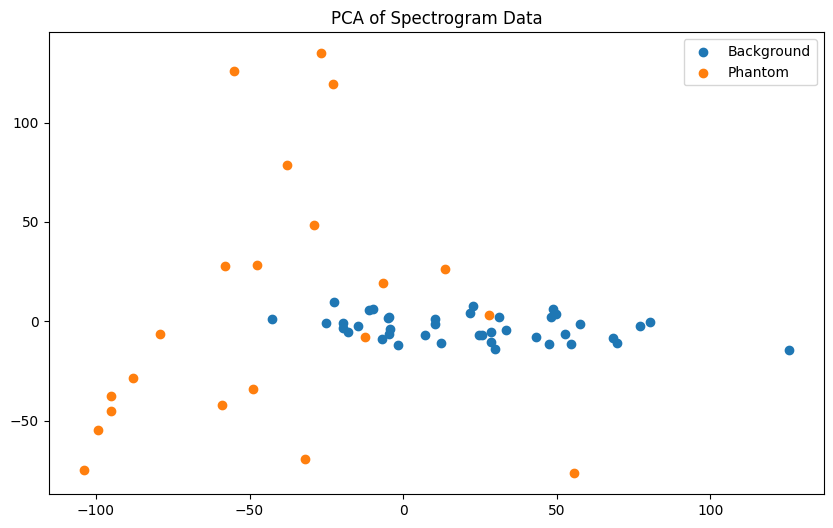

In [98]:
from sklearn.decomposition import PCA

pca_df = df.copy()
label_mapping = {'bg': 0, 'phantom': 1}
pca_df['y'] = pca_df['y'].map(label_mapping)

X = pca_df.drop(['y'], axis=1)
y = pca_df['y']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label='Background')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label='Phantom')
plt.legend()
plt.title('PCA of Spectrogram Data')
plt.show()

## Split data into training and testing

For anomaly detection cases, we don't care about specific drones quite yet. Due to this, we map every drone label as a "drone" with label 1.

In [99]:
df['y'] = df['y'].map(lambda x: 0 if x == 'bg' else 1)

X = df.drop(['y'], axis=1)
y = df['y']

X_bg = X[y == 0]
X_drone = X[y == 1]

# Split background data into train and test sets
X_bg_train, X_bg_test = train_test_split(X_bg, test_size=0.2, random_state=42)

# Use all drone data and some background data for testing
X_test = pd.concat([X_bg_test, X_drone])
y_test = pd.concat([pd.Series([0] * len(X_bg_test)), pd.Series([1] * len(X_drone))])

print("Full dataset distribution:")
print(y.value_counts(normalize=True))

print("\nTest set distribution:")
print(y_test.value_counts(normalize=True))

Full dataset distribution:
y
0    0.66129
1    0.33871
Name: proportion, dtype: float64

Test set distribution:
1    0.7
0    0.3
Name: proportion, dtype: float64


## Autoencoder 

In [103]:
def build_autoencoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    encoded = layers.Dense(16, activation='relu')(x)
    
    # Decoder
    x = layers.Dense(32, activation='relu')(encoded)
    x = layers.Dense(64, activation='relu')(x)
    decoded = layers.Dense(input_shape[0], activation='sigmoid')(x)
    
    autoencoder = Model(inputs, decoded)
    return autoencoder

# Get the number of features
n_features = X_bg_train.shape[1]

# Build and compile the model
model = build_autoencoder((n_features,))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 14884)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       952,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 14884)          │       967,460 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,925,364 (7.34 MB)

 Trainable params: 1,925,364 (7.34 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
X_bg_train_array = X_bg_train.values

# Train the model
history = model.fit(
    X_bg_train_array, X_bg_train_array,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step - loss: 0.0226 - val_loss: 0.0217
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0225 - val_loss: 0.0217
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0225 - val_loss: 0.0216
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0224 - val_loss: 0.0215
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0223 - val_loss: 0.0212
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0219 - val_loss: 0.0205
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0212 - val_loss: 0.0195
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0201 - val_loss: 0.0184
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0188 - val_loss: 0.0174
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0177 - val_loss: 0.0165
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0166 - val_loss: 0.0157
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0157 - val_loss: 0.0150


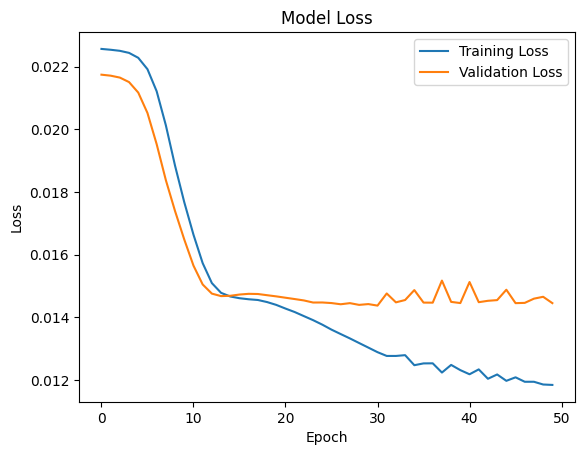

In [105]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [107]:
def detect_anomalies(model, data, threshold):
    reconstructions = model.predict(data)
    mse = np.mean(np.square(data - reconstructions), axis=1)
    return mse > threshold

In [108]:
background_reconstructions = model.predict(X_bg_train_array)
background_mse = np.mean(np.square(X_bg_train_array - background_reconstructions), axis=1)
threshold = np.percentile(background_mse, 95)  # 95th percentile as threshold

# Detect anomalies in test data
X_test_array = X_test.values
anomalies = detect_anomalies(model, X_test_array, threshold)

print(f"Detected {np.sum(anomalies)} anomalies out of {len(X_test)} test samples")

# Calculate performance metrics
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_test, anomalies))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, anomalies))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Detected 21 anomalies out of 30 test samples

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        21

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Confusion Matrix:
[[ 9  0]
 [ 0 21]]


## Z-score for anomaly detection (current implementation)

In [77]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [78]:
def z_score_anomaly_detector(X_train, X_test, threshold=3):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_bg_train)
    X_test_scaled = scaler.transform(X_test)
    
    mean = np.mean(X_train_scaled, axis=0)
    std = np.std(X_train_scaled, axis=0)

    z_scores = np.abs((X_test_scaled - mean) / std)

    # Flag as anomaly if any feature's z-score exceeds the threshold
    max_z_scores = np.max(z_scores, axis=1)
    return max_z_scores, pd.Series(np.where(max_z_scores > threshold, 1, 0))

In [89]:
import warnings
warnings.filterwarnings('ignore')

thresholds = [2,2.5, 3.5, 4, 4.5, 5]
for threshold in thresholds:
    z_scores, y_pred = z_score_anomaly_detector(X_bg_train, X_test, threshold=threshold)
    print(f"Results with threshold {threshold}:")
    print(classification_report(y_test, y_pred))

Results with threshold 2:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.70      1.00      0.82        21

    accuracy                           0.70        30
   macro avg       0.35      0.50      0.41        30
weighted avg       0.49      0.70      0.58        30

Results with threshold 2.5:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.70      1.00      0.82        21

    accuracy                           0.70        30
   macro avg       0.35      0.50      0.41        30
weighted avg       0.49      0.70      0.58        30

Results with threshold 3.5:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.70      1.00      0.82        21

    accuracy                           0.70        30
   macro avg       0.35      0.50      0.41   

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.70      1.00      0.82        21

    accuracy                           0.70        30
   macro avg       0.35      0.50      0.41        30
weighted avg       0.49      0.70      0.58        30



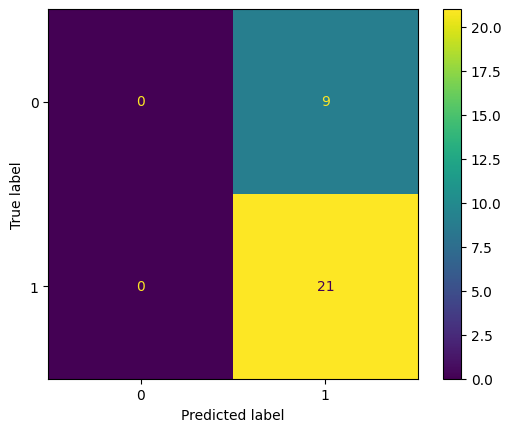

In [80]:
z_scores, y_pred = z_score_anomaly_detector(X_bg_train, X_test, threshold=5)
print(classification_report(y_test, y_pred))
disp_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

# Isolation forest

In [81]:
from sklearn.ensemble import IsolationForest

Contamination level is basically the percent of anomalies expected.

In [82]:
iso_forest = IsolationForest(contamination=0.3)
iso_forest.fit(X_bg_train)

IsolationForest(contamination=0.3)

In [83]:
iso_forest.get_params()

{'bootstrap': False,
 'contamination': 0.3,
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [84]:
y_pred_iso = iso_forest.predict(X_test)

In [85]:
print(y_pred_iso)

[ 1  1  1  1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1
 -1 -1  1 -1 -1  1]


In [86]:
test_iso_predictions = (y_pred_iso == -1).astype(int)

In [87]:
def evaluate_predictions(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    disp_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.56      0.48         9
           1       0.78      0.67      0.72        21

    accuracy                           0.63        30
   macro avg       0.60      0.61      0.60        30
weighted avg       0.67      0.63      0.65        30

Confusion Matrix:


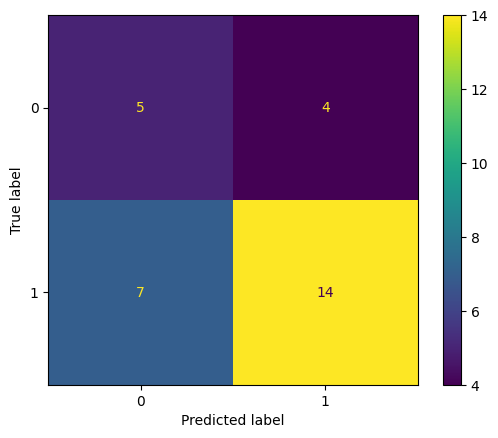

In [88]:
evaluate_predictions(y_test, test_iso_predictions)

### Using custom threshold with isolation forest anomaly scores

The decision function computes the anomaly score for each sample. The decision score is based on the average path length to isolate a sample. This was just for me to understand the how contamination and the decision function worked.

In [49]:
# Get anomaly scores
train_iso_scores = iso_forest.decision_function(X_bg_train)
test_iso_scores = iso_forest.decision_function(X_test)

In [63]:
threshold = np.percentile(train_iso_scores, 25)  # bottom 10% as anomalies
custom_iso_predictions = np.where(test_iso_scores < threshold, 1, 0)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        21

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Confusion Matrix:


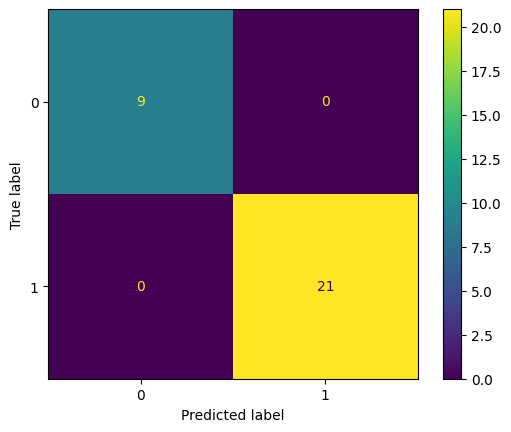

In [64]:
evaluate_predictions(y_test, custom_iso_predictions)

## Local Outlier Factor (LOF)

In [67]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(contamination=0.3, novelty=True)
lof.fit(X_bg_train)

LocalOutlierFactor(contamination=0.3, novelty=True)

In [68]:
y_pred_lof = lof.predict(X_test)

In [69]:
print(y_pred_lof)

[ 1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1]


In [70]:
test_lof_predictions = (y_pred_lof == -1).astype(int)
print(test_lof_predictions)

[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        21

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Confusion Matrix:


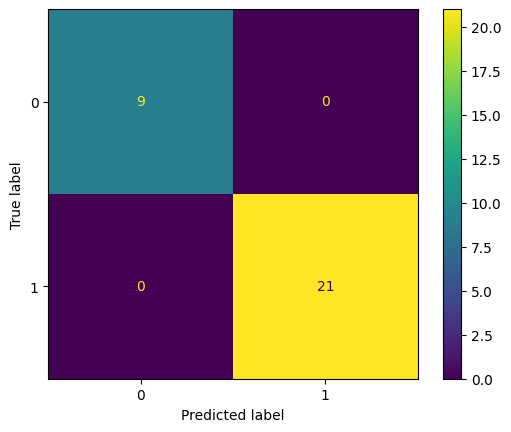

In [71]:
evaluate_predictions(y_test, test_lof_predictions)

## Cross validation

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

def custom_cross_validation(X, y, n_splits=5):
    # Separate background and drone data
    X_bg = X[y == 0]
    X_drone = X[y == 1]
    y_bg = y[y == 0]
    y_drone = y[y == 1]

    # Create stratified k-fold for background data
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores = []

    for fold, (train_index, val_index) in enumerate(skf.split(X_bg, y_bg), 1):
        # Split background data
        X_bg_train, X_bg_val = X_bg.iloc[train_index], X_bg.iloc[val_index]
        
        # Combine validation background data with all drone data for testing
        X_val = pd.concat([X_bg_val, X_drone])
        y_val = pd.concat([pd.Series([0] * len(X_bg_val)), pd.Series([1] * len(X_drone))])
        
        # Train Isolation Forest
        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        iso_forest.fit(X_bg_train)
        
        # Predict anomaly scores
        anomaly_scores = -iso_forest.decision_function(X_val)
        
        # Calculate AUC-ROC score
        auc_score = roc_auc_score(y_val, anomaly_scores)
        scores.append(auc_score)
        
        print(f"Fold {fold} AUC-ROC: {auc_score:.3f}")
    
    print(f"\nMean AUC-ROC: {np.mean(scores):.3f} (+/- {np.std(scores) * 2:.3f})")
    
    return scores
cv_scores = custom_cross_validation(X, y)

In [ ]:
import sys
import numpy as np
import pandas as pd
import sklearn
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")